In [1]:
import pandas as pd
import glob
import os
import csv
from datetime import datetime, timedelta
import json
from IPython.display import display, HTML
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")

### Fixing power difference

In [142]:
#Only needed to run once but left in incase adjustments need to be made again at a later date
power_diff = 9.162812939836797
start_increase = "2022-05-23 09:48:48"
end_increase = "2022-05-24 14:00:00"

increased_section = df[start_increase : end_increase]
increased_section = increased_section.apply(lambda x: x - power_diff)

df.update(increased_section)

<AxesSubplot:xlabel='datetime'>

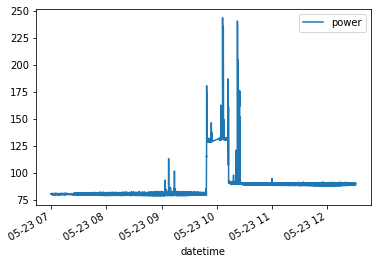

In [122]:
#Before
df['23-05-2022 07:00':'23-05-2022 12:30'].plot()

<AxesSubplot:xlabel='datetime'>

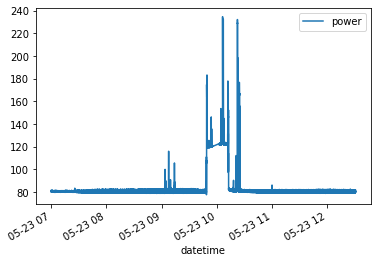

In [143]:
#After
df['23-05-2022 07:00':'23-05-2022 12:30'].plot()

In [144]:
df.to_csv("grouped_unrounded_adjusted.csv")

In [19]:
#Combining 4k timing data with other data
with open("power/db_vmaf_yuv_2022-06-09.json") as f:
            vmaf_data = json.load(f)
        
with open("power/db_vmaf_yuv_2160-2022-06-29.json") as f:
            vmaf_data_2160 = json.load(f)
        
for key in vmaf_data.keys():
    start_index = int(list(vmaf_data[key].keys())[-1])
    for val in vmaf_data_2160[key].values():
        vmaf_data[key][start_index] = val
        start_index += 1

In [21]:
with open("power/db_vmaf_yuv_combined.json", "w") as f:
    json.dump(vmaf_data, f)

# Main Power Calculation Class

In [2]:
class VideoData:
    def __init__(self, log_csv_name, vmaf_csv_name, vmaf = False):
        df = pd.read_csv(log_csv_name, dtype={'datetime': "string", "power": float}, low_memory=False)
        df['datetime'] = pd.to_datetime(df['datetime'])
        df.set_index('datetime', inplace=True)
        
        with open(vmaf_csv_name) as f:
            vmaf_data = json.load(f)
        
        self.log_df = df
        self.vmaf_data = vmaf_data
        #Change if you want to include VVC (skews graph)
        self.violin_include_VVC = False
        self.vmaf = vmaf
        
    def calc_energies(self):
        self.get_videos_flat()
        avg_energy = [self.get_energy_video(time) for time in self.get_video_times()]
        
        #Target encode energy is always at end of array so can sum for energy used during evaluation and target
        evaluated_qp_energy = [sum(energy[:-1])[0] for energy in avg_energy]
        target_encode_energy = [energy[-1][0] for energy in avg_energy]
        
        #Formatting for df, getting everything in nice lists
        video_names = [video['video_name'] for video in self.videos_flat.values()]
        res = [video['resolution'] for video in self.videos_flat.values()]
        codec = [video['codec'] for video in self.videos_flat.values()]
        genre = [name.split("_")[0] for name in video_names]
        bitrate = [video['target_encode']['bitrate'] for video in self.videos_flat.values()]
        encoding_energy = [qp + target for qp, target in zip(evaluated_qp_energy, target_encode_energy)]
        vmaf_bitrate = [video["vmaf_target"]["bitrate"] if "vmaf_target" in video else video['target_encode']['bitrate'] for video in self.videos_flat.values()]
        vmaf = [video["vmaf_target"]["vmaf"] if "vmaf_target" in video else video['target_encode']['vmaf'] for video in self.videos_flat.values()]

        d = {"codec": codec, "video_name": video_names, "genre": genre, "resolution": res, "target bitrate": bitrate, "vmaf bitrate": vmaf_bitrate, "vmaf": vmaf, "evaluated qp energy (J)": evaluated_qp_energy, "target encode energy (J)": target_encode_energy, "encoding energy (J)": encoding_energy}

        powers_df = pd.DataFrame(data = d)
        
        self.powers_df = powers_df
        
    def get_energy_video(self, time):
        #average power in watts
        avg_power = [self.log_df[time[0] : time[1]].mean() for time in time]
        #energy in joules
        energy = [power * (datetime.strptime(time[1], "%Y-%m-%d %H:%M:%S.%f") - datetime.strptime(time[0], "%Y-%m-%d %H:%M:%S.%f")).total_seconds() for power, time in zip(avg_power, time)]

        return energy

    def get_video_time(self, video):
        return [[qp["start_time"], qp["end_time"]] for qp in video["evaluated_qps"]] + [[video["target_encode"]["start_time"], video["target_encode"]["end_time"]]]

    def get_video_time_vmaf(self, video):
        return [[qp["start_time_vmaf"], qp["end_time_vmaf"]] for qp in video["evaluated_qps"]] + [[video["target_encode"]["start_time_vmaf"], video["target_encode"]["end_time_vmaf"]]]
    
    #Get list of lists containing start and end time for all parts of encoding for given video
    def get_video_times(self):
        if self.vmaf:
            video_times = [self.get_video_time_vmaf(video) for video in self.videos_flat.values()]
        else:
            video_times = [self.get_video_time(video) for video in self.videos_flat.values()]
        
        return video_times
    
    #Flatten object and add codec to each video dict
    def get_videos_flat(self):
        vids_flat = {}

        for codec in self.vmaf_data.keys():

            for i, vid in enumerate(self.vmaf_data[codec].values()):
                if "error" in vid:
                    continue
                vid["codec"] = codec
                vids_flat[f"{i}-{codec}"] = vid
                
        self.videos_flat = vids_flat

    def fill_complete_csv(self):
        if not self.videos_flat:
            self.get_videos_flat()

        for vid in self.videos_flat.values():
            video_times = self.get_video_time(vid)
            video_times_vmaf = self.get_video_time_vmaf(vid)

            energies = self.get_energy_video(video_times)
            energies_vmaf = self.get_energy_video(video_times_vmaf)
            
            evaluated_qp_energy = sum(energies[:-1])[0]
            target_encode_energy = energies[-1][0]

            evaluated_qp_energy_vmaf = sum(energies_vmaf[:-1])[0]
            target_encode_energy_vmaf = energies_vmaf[-1][0]
            
            for i, qp in enumerate(vid["evaluated_qps"]):
                qp["energy"] = energies[i][0]
                qp["energy_vmaf"] = energies_vmaf[i][0]
                
            vid["target_encode"]["energy"] = target_encode_energy
            vid["target_encode"]["energy_vmaf"] = target_encode_energy_vmaf
            
            vid["evaluated_qp_energy"] = evaluated_qp_energy
            vid["evaluated_qp_energy"] = evaluated_qp_energy_vmaf

    def get_violin_graphs(self):
        df = self.powers_df
        if not self.violin_include_VVC:
            df = self.powers_df[self.powers_df.codec != "VVC"]

        sns.catplot(x="resolution", y="encoding energy (J)", col="genre", hue="codec",
                    data=df, palette="Set2", scale="count", inner="quartile",
                    scale_hue=False, bw=.2, kind="violin",col_wrap=5,linewidth=.5)
        
        if self.vmaf:
            plt.savefig("res_vs_encoding_energy_violin_vmaf_VVC_2160.pdf" if self.violin_include_VVC else "res_vs_encoding_energy_violin_vmaf_2160.pdf")
        else:
            plt.savefig("res_vs_encoding_energy_violin__VVC_2160.pdf" if self.violin_include_VVC else "res_vs_encoding_energy_violin_2160.pdf")

    def get_res_energy_graph(self):
        df = self.powers_df
        if not self.violin_include_VVC:
            df = self.powers_df[self.powers_df.codec != "VVC"]

        sns.boxplot(x="resolution", y="encoding energy (J)", hue="codec",
                 data=df, palette="Set3", showfliers = False)
        if self.vmaf:
            plt.savefig("res_vs_encoding_energy_box_vmaf_VVC_2160.pdf" if self.violin_include_VVC else "res_vs_encoding_energy_box_vmaf_2160.pdf")
        else:
            plt.savefig("res_vs_encoding_energy_box_VVC_2160.pdf" if self.violin_include_VVC else "res_vs_encoding_energy_box_2160.pdf")
    def get_res_bitrate_graph(self):
        df = self.powers_df
        if not self.violin_include_VVC:
            df = self.powers_df[self.powers_df.codec != "VVC"]
            
        if self.vmaf:
            sns.boxplot(x="resolution", y="vmaf bitrate", hue="codec", 
                        data=df, palette="Set3", showfliers = False)
            plt.savefig("bitrate_vs_encoding_energy_box_vmaf_VVC_2160.pdf" if self.violin_include_VVC else "bitrate_vs_encoding_energy_box_vmaf_2160.pdf")
        else:
            sns.boxplot(x="resolution", y="target bitrate", hue="codec", 
                        data=df, palette="Set3", showfliers = False)
            plt.savefig("bitrate_vs_encoding_energy_box_VVC_2160.pdf" if self.violin_include_VVC else "bitrate_vs_encoding_energy_box_2160.pdf")
    


### No 4k Instance

In [4]:
VideoDataInstance = VideoData("grouped_unrounded_adjusted.csv", "power/db_vmaf_yuv_2022-06-09.json", vmaf=False)

### 4K Instance

In [3]:
VideoDataInstance = VideoData("grouped_unrounded_2160.csv", "power/db_vmaf_yuv_combined.json", vmaf=True)

In [4]:
# Will do all calcs required and fill 'powers_df'
VideoDataInstance.calc_energies()

In [5]:
VideoDataInstance.powers_df

codec            video_name      genre  resolution  target bitrate  \
0     libvpx-vp9  Animation_1080P-05f8  Animation         360        284.8130   
1     libvpx-vp9  Animation_1080P-05f8  Animation         720        994.4860   
2     libvpx-vp9  Animation_1080P-05f8  Animation        1080       1759.7110   
3     libvpx-vp9  CoverSong_1080P-0188  CoverSong         360        271.0210   
4     libvpx-vp9      HowTo_1080P-0267      HowTo         360        265.2110   
...          ...                   ...        ...         ...             ...   
2127         VVC  Animation_1080P-4be3  Animation        1080       1997.7283   
2128         VVC  CoverSong_1080P-3409  CoverSong        1080       1748.0788   
2129         VVC  Animation_2160P-41dc  Animation        2160      11762.0813   
2130         VVC     Gaming_2160P-2cb1     Gaming        2160      17345.9342   
2131         VVC        HDR_2160P-70ca        HDR        2160      13315.1461   

      vmaf bitrate       vmaf  evaluated qp energy (J)  \
0         284.8130  79.578062             23477.421384   
1         994.4860  91.806144             18732.983549   
2        1759.7110  94.331030             23695.407206   
3         271.0210  34.804728             31379.849923   
4         265.2110  87.099016             23515.710156   
...            ...        ...                      ...   
2127     1166.1739  89.356218             18580.745230   
2128     1112.0172  88.745158             21159.483729   
2129     1765.6318  81.366367             51751.343195   
2130     6779.7111  71.902978            198234.625302   
2131    13315.1461  40.794716            353871.280577   

      target encode energy (J)  encoding energy (J)  
0                  4664.825046         28142.246429  
1                  4699.395987         23432.379536  
2                  4690.241233         28385.648440  
3                  5232.526578         36612.376501  
4                  5826.178261         29341.888416  
...                        ...                  ...  
2127               4596.081772         23176.827002  
2128               5307.912984         26467.396713  
2129              12890.629937         64641.973132  
2130              48463.014860        246697.640162  
2131              70551.905506        424423.186083  

[2132 rows x 10 columns]

In [6]:
#Fills 'videos_flat' with energies etc, ready to export
VideoDataInstance.fill_complete_csv()

In [7]:
VideoDataInstance.videos_flat

{'0-libvpx-vp9': {'video_name': 'Animation_1080P-05f8',
  'resolution': 360,
  'evaluated_qps': [{'output_video_file_path': '/home/csxds/video_temp/videos/Animation_05f8_640x360_libvpx-vp9_27.mp4',
    'bitrate': 1650.553,
    'start_time': '2022-05-02 15:40:31.537',
    'end_time': '2022-05-02 15:41:04.308',
    'qp': 27,
    'vmaf': 92.546579,
    'start_time_vmaf': '2022-05-02 15:41:05.883',
    'end_time_vmaf': '2022-05-02 15:41:48.925',
    'vvcdec_output_path': None,
    'resized': True,
    'energy': 3758.9199394736843,
    'energy_vmaf': 4669.644514166668},
   {'output_video_file_path': '/home/csxds/video_temp/videos/Animation_05f8_640x360_libvpx-vp9_33.mp4',
    'bitrate': 1058.271,
    'start_time': '2022-05-02 15:41:49.071',
    'end_time': '2022-05-02 15:42:17.777',
    'qp': 33,
    'vmaf': 90.232278,
    'start_time_vmaf': '2022-05-02 15:42:19.354',
    'end_time_vmaf': '2022-05-02 15:43:02.277',
    'vvcdec_output_path': None,
    'resized': True,
    'energy': 3306.9503

## Video Distributions

In [13]:
power_df = VideoDataInstance.powers_df
display(power_df.groupby(["codec"]).size())
display(power_df[power_df.resolution == 360].groupby(["codec"]).size())
display(power_df[power_df.resolution == 720].groupby(["codec"]).size())
display(power_df[power_df.resolution == 1080].groupby(["codec"]).size())

codec
VVC            78
libsvtav1     503
libvpx-vp9    522
libx264       515
libx265       514
dtype: int64

codec
libsvtav1     147
libvpx-vp9    157
libx264       154
libx265       154
dtype: int64

codec
libsvtav1     155
libvpx-vp9    160
libx264       157
libx265       157
dtype: int64

codec
VVC            75
libsvtav1     147
libvpx-vp9    151
libx264       150
libx265       149
dtype: int64

In [14]:
VideoDataInstance.powers_df.groupby(["genre"]).size()

genre
Animation         222
CoverSong         244
Gaming             45
HDR                41
HowTo             192
Lecture           272
LiveMusic         199
LyricVideo        149
MusicVideo        245
NewsClip          199
Sports             40
TelevisionClip    200
VR                 40
VerticalVideo       4
Vlog               40
dtype: int64

## Graphs

variance          sd
genre                                   
Animation       47544.147466  218.046205
CoverSong        7815.882443   88.407480
HowTo            8281.143483   91.000788
Lecture         15881.822165  126.023102
LiveMusic        4370.190830   66.107419
LyricVideo      21692.154949  147.282568
MusicVideo       3122.070961   55.875495
NewsClip        10011.177296  100.055871
TelevisionClip   5169.938129   71.902282

variance          sd
genre                                    
Animation       442432.777444  665.156205
CoverSong        71498.190665  267.391456
HowTo           100808.762154  317.503956
Lecture         316494.891986  562.578787
LiveMusic        41361.100636  203.374287
LyricVideo      240135.696439  490.036424
MusicVideo       46432.806195  215.482728
NewsClip         91835.572134  303.043845
TelevisionClip   52572.016496  229.285884

variance           sd
genre                                    
Animation       1.530823e+06  1237.264254
CoverSong       2.817092e+05   530.762800
HowTo           6.650355e+05   815.497112
Lecture         6.870346e+05   828.875483
LiveMusic       3.752503e+05   612.576759
LyricVideo      1.705942e+06  1306.117300
MusicVideo      4.650022e+05   681.910697
NewsClip        4.161600e+05   645.104671
TelevisionClip  2.637594e+05   513.575155

variance           sd
genre                                   
Animation      2.376913e+07  4875.359785
Gaming         1.657450e+07  4071.179013
HDR            3.068207e+07  5539.139815
Sports         3.930518e+07  6269.384662
VR             6.164512e+06  2482.843526
VerticalVideo  9.687016e+06  3112.397221
Vlog           1.886067e+07  4342.886918

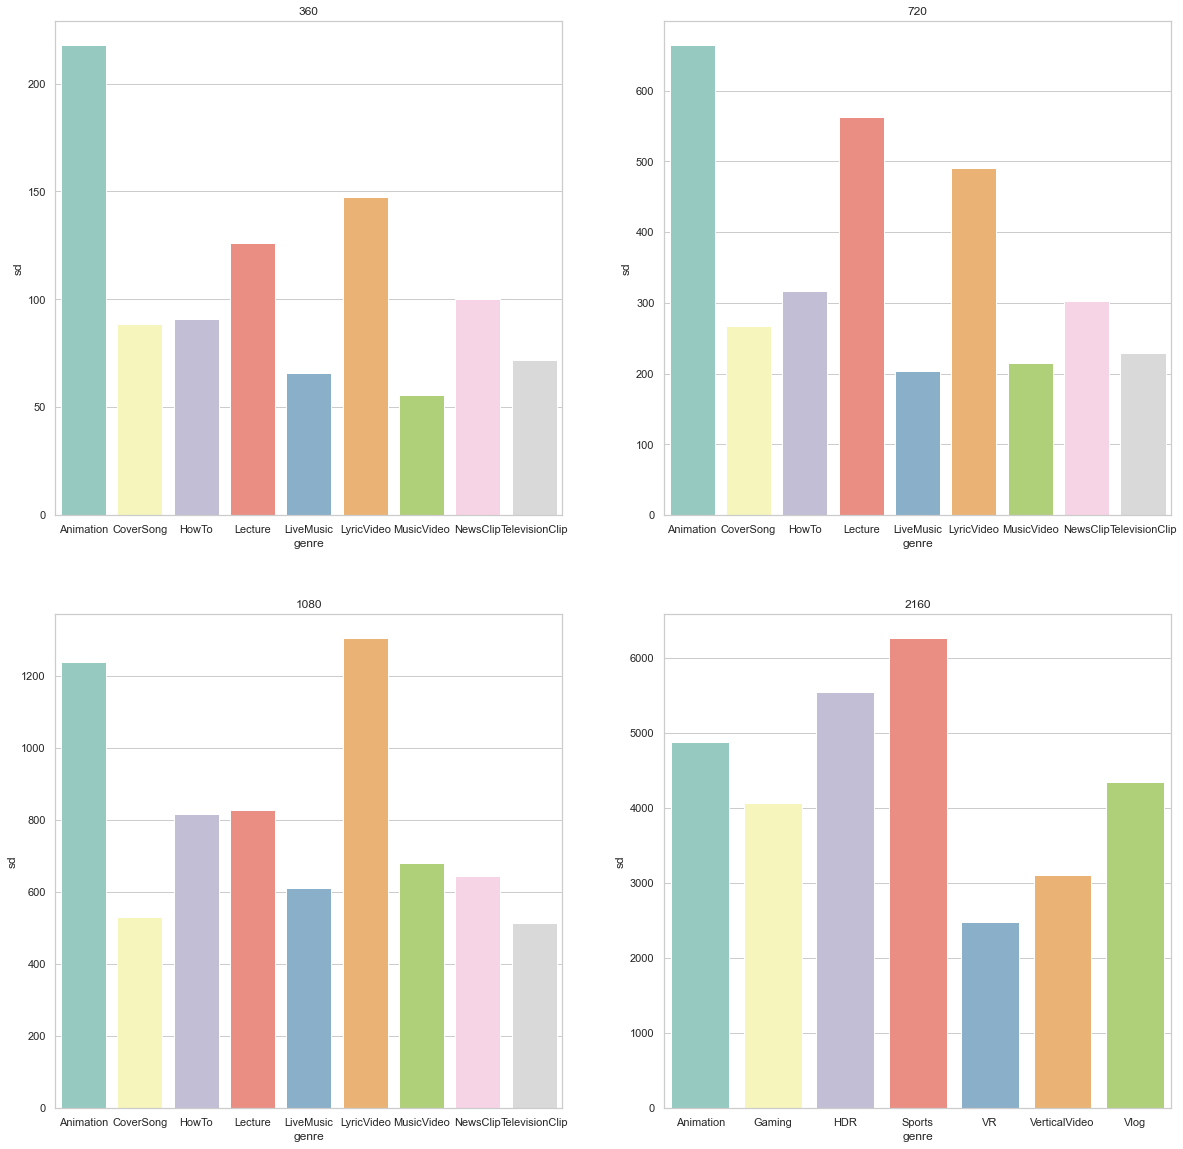

In [74]:
variance_dfs = {}
resolutions = [360, 720, 1080, 2160]

for res in resolutions:
    variance = VideoDataInstance.powers_df[VideoDataInstance.powers_df["resolution"] == res].groupby(["genre"]).var()["vmaf bitrate"]
    variance_dfs[res] = pd.DataFrame({"variance": variance, "sd": variance**(1/2)})
    
plt.figure(figsize=(20,20))    


for i, df in enumerate(variance_dfs.values(), 1):
    display(df)
    plt.subplot(2, 2, i)
    g = sns.barplot(x=df.index, y="sd", 
                data=df, palette="Set3")
    g.set_title(str(resolutions[i - 1]))
    
plt.savefig("standard_deviation.pdf")
plt.show()

In [ ]:
test_df = VideoDataInstance.powers_df[VideoDataInstance.powers_df.codec != "VVC"]
test_df = test_df[test_df.genre == "TelevisionClip"]
test_df = test_df.query('codec == "libx265" or codec == "libvpx-vp9"')
# test_df = test_df[test_df.codec == "libx265" or test_df.codec == "libvpx-vp9"]
test_df = test_df[test_df.resolution == 1080]
# test_df.to_excel("power_df.xlsx")

<AxesSubplot:xlabel='vmaf bitrate', ylabel='vmaf'>

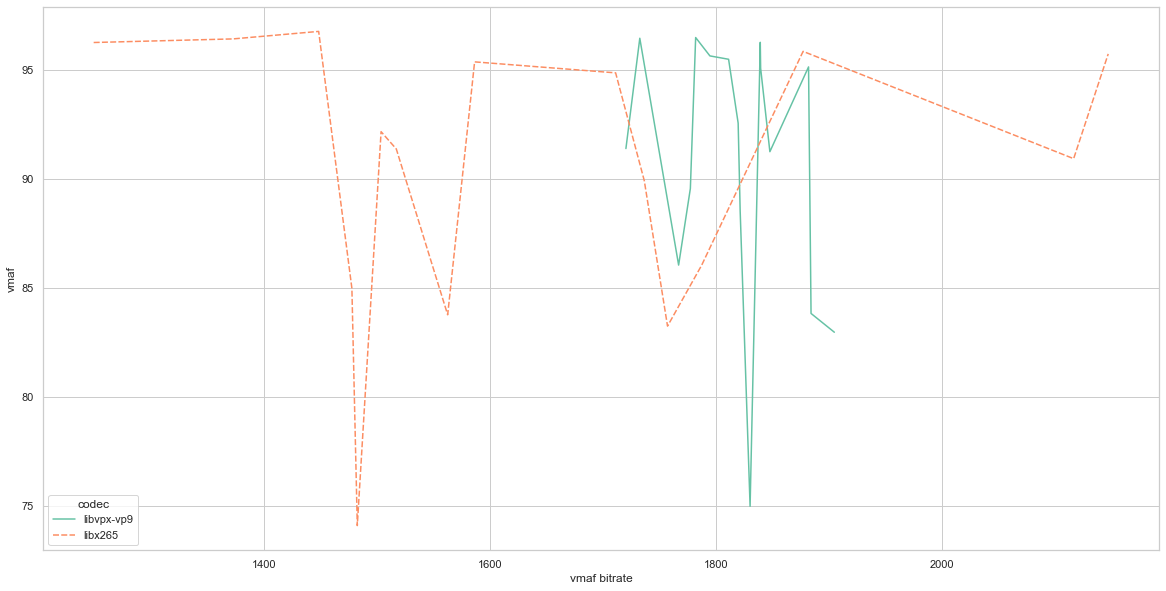

In [9]:
plt.figure(figsize=(20, 10))
sns.lineplot(x="vmaf bitrate", y="vmaf", hue="codec", style="codec", data=test_df, palette="Set2", ci=None, sort=True)

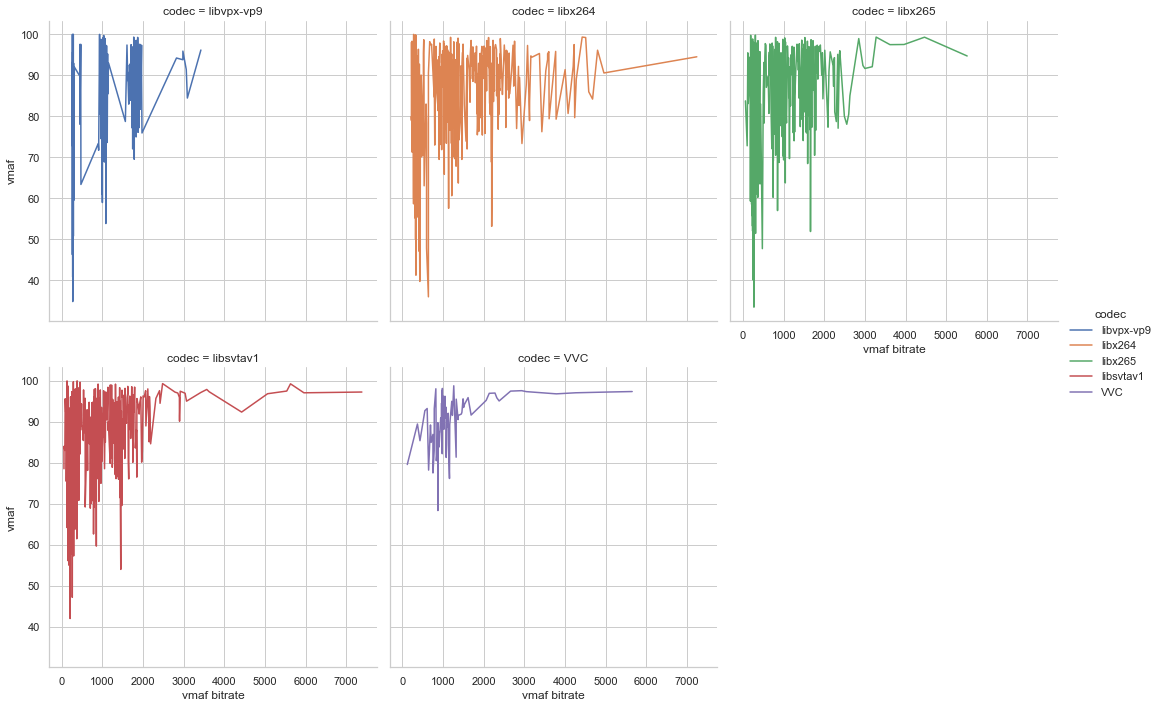

In [214]:
sns.relplot(data=VideoDataInstance.powers_df, x="vmaf bitrate", y="vmaf", hue="codec", col="codec", col_wrap=3, kind="line", legend="full")

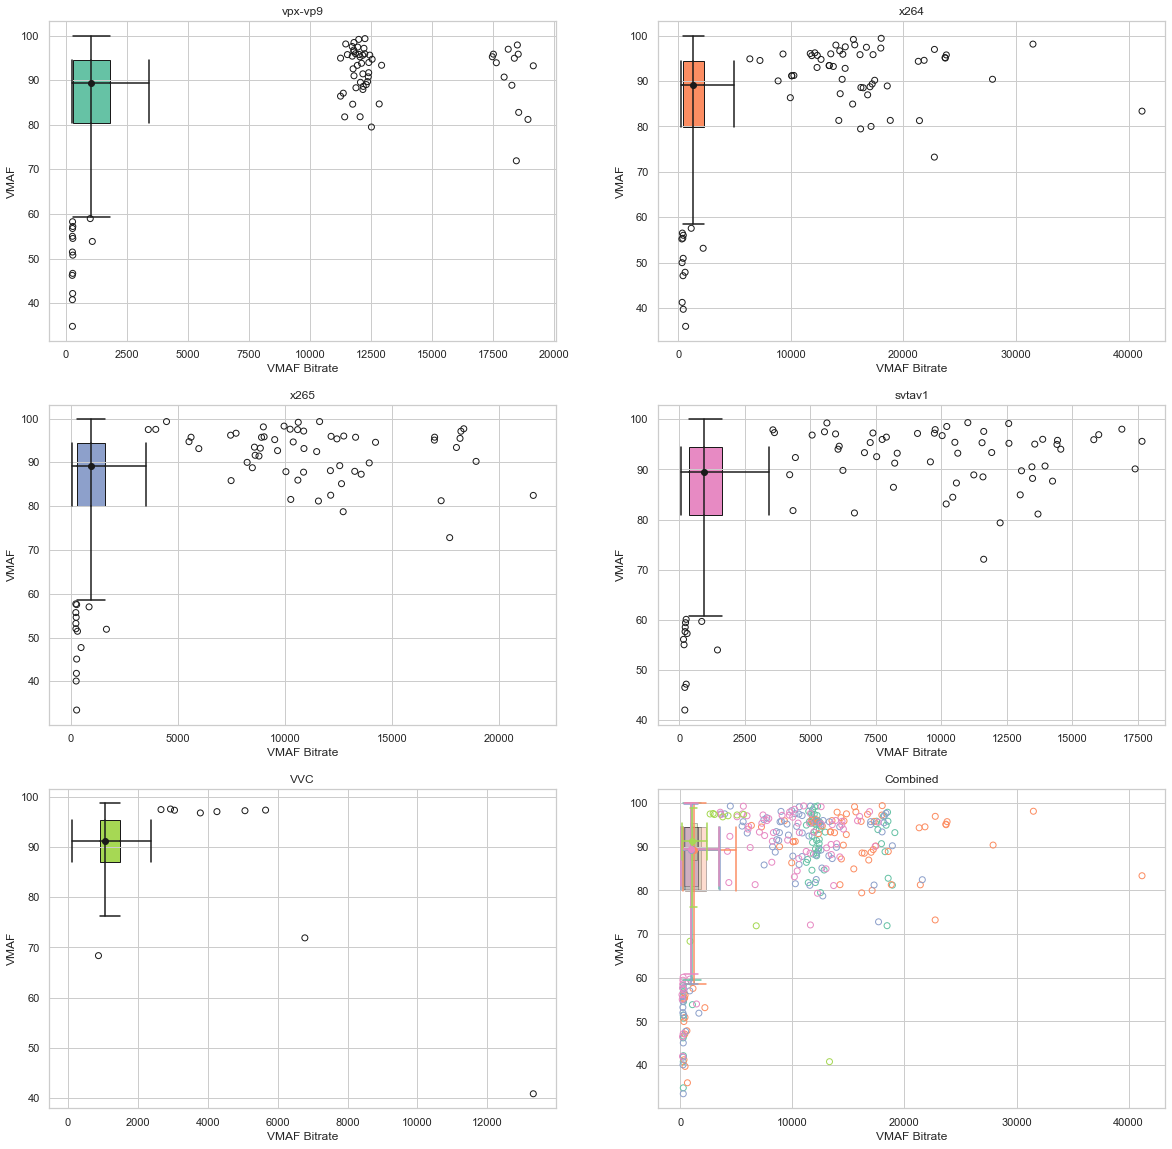

In [20]:
#https://stackoverflow.com/questions/53849636/draw-a-double-box-plot-chart-2-axes-box-plot-box-plot-correlation-diagram-in
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D

def boxplot_2d(x,y, ax, whis=1.5, c=sns.color_palette("Set2")[0], color_lines=False):
    xlimits = [np.percentile(x, q) for q in (25, 50, 75)]
    ylimits = [np.percentile(y, q) for q in (25, 50, 75)]

    ##the box
    box = Rectangle(
        (xlimits[0],ylimits[0]),
        (xlimits[2]-xlimits[0]),
        (ylimits[2]-ylimits[0]),
        color=c,
        ec = 'k',
        zorder=0,
        alpha=0.3 if color_lines else 1
    )
    ax.add_patch(box)

    ##the x median
    vline = Line2D(
        [xlimits[1],xlimits[1]],[ylimits[0],ylimits[2]],
        color= c if color_lines else 'k',
        zorder=1
    )
    ax.add_line(vline)

    ##the y median
    hline = Line2D(
        [xlimits[0],xlimits[2]],[ylimits[1],ylimits[1]],
        color=c if color_lines else 'k',
        zorder=1
    )
    ax.add_line(hline)

    ##the central point
    ax.plot([xlimits[1]],[ylimits[1]], color=c if color_lines else 'k', marker='o')

    ##the x-whisker
    ##defined as in matplotlib boxplot:
    ##As a float, determines the reach of the whiskers to the beyond the
    ##first and third quartiles. In other words, where IQR is the
    ##interquartile range (Q3-Q1), the upper whisker will extend to
    ##last datum less than Q3 + whis*IQR). Similarly, the lower whisker
    ####will extend to the first datum greater than Q1 - whis*IQR. Beyond
    ##the whiskers, data are considered outliers and are plotted as
    ##individual points. Set this to an unreasonably high value to force
    ##the whiskers to show the min and max values. Alternatively, set this
    ##to an ascending sequence of percentile (e.g., [5, 95]) to set the
    ##whiskers at specific percentiles of the data. Finally, whis can
    ##be the string 'range' to force the whiskers to the min and max of
    ##the data.
    iqr = xlimits[2]-xlimits[0]

    ##left
    left = np.min(x[x > xlimits[0]-whis*iqr])
    whisker_line = Line2D(
        [left, xlimits[0]], [ylimits[1],ylimits[1]],
        color = c if color_lines else 'k',
        zorder = 1
    )
    ax.add_line(whisker_line)
    whisker_bar = Line2D(
        [left, left], [ylimits[0],ylimits[2]],
        color = c if color_lines else 'k',
        zorder = 1
    )
    ax.add_line(whisker_bar)

    ##right
    right = np.max(x[x < xlimits[2]+whis*iqr])
    whisker_line = Line2D(
        [right, xlimits[2]], [ylimits[1],ylimits[1]],
        color = c if color_lines else 'k',
        zorder = 1
    )
    ax.add_line(whisker_line)
    whisker_bar = Line2D(
        [right, right], [ylimits[0],ylimits[2]],
        color = c if color_lines else 'k',
        zorder = 1
    )
    ax.add_line(whisker_bar)

    ##the y-whisker
    iqr = ylimits[2]-ylimits[0]

    ##bottom
    bottom = np.min(y[y > ylimits[0]-whis*iqr])
    whisker_line = Line2D(
        [xlimits[1],xlimits[1]], [bottom, ylimits[0]], 
        color = c if color_lines else 'k',
        zorder = 1
    )
    ax.add_line(whisker_line)
    whisker_bar = Line2D(
        [xlimits[0],xlimits[2]], [bottom, bottom], 
        color = c if color_lines else 'k',
        zorder = 1
    )
    ax.add_line(whisker_bar)

    ##top
    top = np.max(y[y < ylimits[2]+whis*iqr])
    whisker_line = Line2D(
        [xlimits[1],xlimits[1]], [top, ylimits[2]], 
        color = c if color_lines else 'k',
        zorder = 1
    )
    ax.add_line(whisker_line)
    whisker_bar = Line2D(
        [xlimits[0],xlimits[2]], [top, top], 
        color = c if color_lines else 'k',
        zorder = 1
    )
    ax.add_line(whisker_bar)

    ##outliers
    mask = (x<left)|(x>right)|(y<bottom)|(y>top)
    ax.scatter(
        x[mask],y[mask],
        facecolors='none', edgecolors=c if color_lines else 'k'
    )

#the figure and axes
fig,((ax1,ax2),(ax3,ax4),(ax5,ax6)) = plt.subplots(figsize=(20,20),nrows=3 ,ncols=2)

boxplot_2d(VideoDataInstance.powers_df[VideoDataInstance.powers_df["codec"] == "libvpx-vp9"]["vmaf bitrate"], VideoDataInstance.powers_df[VideoDataInstance.powers_df["codec"] == "libvpx-vp9"]["vmaf"], ax=ax1)
ax1.set_xlabel("VMAF Bitrate")
ax1.set_ylabel("VMAF")
ax1.set_title("vpx-vp9")

boxplot_2d(VideoDataInstance.powers_df[VideoDataInstance.powers_df["codec"] == "libx264"]["vmaf bitrate"], VideoDataInstance.powers_df[VideoDataInstance.powers_df["codec"] == "libx264"]["vmaf"], ax=ax2, c=sns.color_palette("Set2")[1])
ax2.set_xlabel("VMAF Bitrate")
ax2.set_ylabel("VMAF")
ax2.set_title("x264")

boxplot_2d(VideoDataInstance.powers_df[VideoDataInstance.powers_df["codec"] == "libx265"]["vmaf bitrate"], VideoDataInstance.powers_df[VideoDataInstance.powers_df["codec"] == "libx265"]["vmaf"], ax=ax3, c=sns.color_palette("Set2")[2])
ax3.set_xlabel("VMAF Bitrate")
ax3.set_ylabel("VMAF")
ax3.set_title("x265")

boxplot_2d(VideoDataInstance.powers_df[VideoDataInstance.powers_df["codec"] == "libsvtav1"]["vmaf bitrate"], VideoDataInstance.powers_df[VideoDataInstance.powers_df["codec"] == "libsvtav1"]["vmaf"], ax=ax4, c=sns.color_palette("Set2")[3])
ax4.set_xlabel("VMAF Bitrate")
ax4.set_ylabel("VMAF")
ax4.set_title("svtav1")

boxplot_2d(VideoDataInstance.powers_df[VideoDataInstance.powers_df["codec"] == "VVC"]["vmaf bitrate"], VideoDataInstance.powers_df[VideoDataInstance.powers_df["codec"] == "VVC"]["vmaf"], ax=ax5, c=sns.color_palette("Set2")[4])
ax5.set_xlabel("VMAF Bitrate")
ax5.set_ylabel("VMAF")
ax5.set_title("VVC")

# boxplot_2d(VideoDataInstance.powers_df["vmaf bitrate"], VideoDataInstance.powers_df["vmaf"], ax=ax6, c=sns.color_palette("Set2")[5])
boxplot_2d(VideoDataInstance.powers_df[VideoDataInstance.powers_df["codec"] == "libvpx-vp9"]["vmaf bitrate"], VideoDataInstance.powers_df[VideoDataInstance.powers_df["codec"] == "libvpx-vp9"]["vmaf"], ax=ax6, color_lines=True)
boxplot_2d(VideoDataInstance.powers_df[VideoDataInstance.powers_df["codec"] == "libx264"]["vmaf bitrate"], VideoDataInstance.powers_df[VideoDataInstance.powers_df["codec"] == "libx264"]["vmaf"], ax=ax6, c=sns.color_palette("Set2")[1], color_lines=True)
boxplot_2d(VideoDataInstance.powers_df[VideoDataInstance.powers_df["codec"] == "libx265"]["vmaf bitrate"], VideoDataInstance.powers_df[VideoDataInstance.powers_df["codec"] == "libx265"]["vmaf"], ax=ax6, c=sns.color_palette("Set2")[2], color_lines=True)
boxplot_2d(VideoDataInstance.powers_df[VideoDataInstance.powers_df["codec"] == "libsvtav1"]["vmaf bitrate"], VideoDataInstance.powers_df[VideoDataInstance.powers_df["codec"] == "libsvtav1"]["vmaf"], ax=ax6, c=sns.color_palette("Set2")[3], color_lines=True)
boxplot_2d(VideoDataInstance.powers_df[VideoDataInstance.powers_df["codec"] == "VVC"]["vmaf bitrate"], VideoDataInstance.powers_df[VideoDataInstance.powers_df["codec"] == "VVC"]["vmaf"], ax=ax6, c=sns.color_palette("Set2")[4], color_lines=True)
ax6.set_xlabel("VMAF Bitrate")
ax6.set_ylabel("VMAF")
ax6.set_title("Combined")

plt.savefig("2d_boxplots_combined_res_2160.pdf")

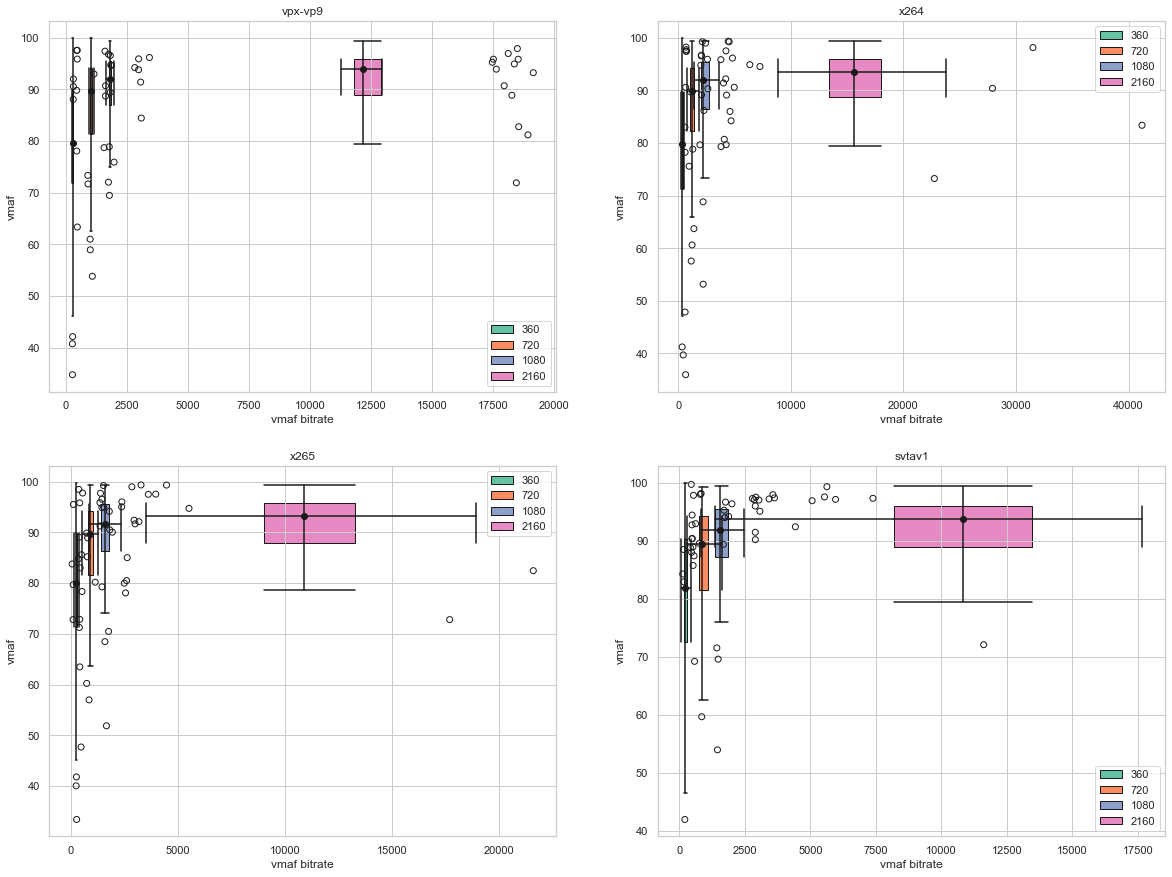

In [22]:
#https://stackoverflow.com/questions/53849636/draw-a-double-box-plot-chart-2-axes-box-plot-box-plot-correlation-diagram-in
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D

def boxplot_2d_multiple(data, x_label, y_label, ax, whis=1.5, c=sns.color_palette("Set2")[0], color_lines=False):
    
    boxes = []
    
    for i, res in enumerate([360, 720, 1080, 2160]):
        c = sns.color_palette("Set2")[i]
        x = data[data["resolution"] == res][x_label]
        y = data[data["resolution"] == res][y_label]
    
        xlimits = [np.percentile(x, q) for q in (25, 50, 75)]
        ylimits = [np.percentile(y, q) for q in (25, 50, 75)]

        ##the box
        box = Rectangle(
            (xlimits[0],ylimits[0]),
            (xlimits[2]-xlimits[0]),
            (ylimits[2]-ylimits[0]),
            color=c,
            ec = 'k',
            zorder=0,
            alpha=0.3 if color_lines else 1
        )
        boxes.append(box)
        ax.add_patch(box)
#         ax.add_patch(box)

        ##the x median
        ax.add_line(Line2D(
            [xlimits[1],xlimits[1]],[ylimits[0],ylimits[2]],
            color= c if color_lines else 'k',
            zorder=1
        ))
#         ax.add_line(vline)

        ##the y median
        ax.add_line(Line2D(
            [xlimits[0],xlimits[2]],[ylimits[1],ylimits[1]],
            color=c if color_lines else 'k',
            zorder=1
        ))
#         ax.add_line(hline)

        ##the central point
        ax.plot([xlimits[1]],[ylimits[1]], color=c if color_lines else 'k', marker='o')

        ##the x-whisker
        ##defined as in matplotlib boxplot:
        ##As a float, determines the reach of the whiskers to the beyond the
        ##first and third quartiles. In other words, where IQR is the
        ##interquartile range (Q3-Q1), the upper whisker will extend to
        ##last datum less than Q3 + whis*IQR). Similarly, the lower whisker
        ####will extend to the first datum greater than Q1 - whis*IQR. Beyond
        ##the whiskers, data are considered outliers and are plotted as
        ##individual points. Set this to an unreasonably high value to force
        ##the whiskers to show the min and max values. Alternatively, set this
        ##to an ascending sequence of percentile (e.g., [5, 95]) to set the
        ##whiskers at specific percentiles of the data. Finally, whis can
        ##be the string 'range' to force the whiskers to the min and max of
        ##the data.
        iqr = xlimits[2]-xlimits[0]

        ##left
        left = np.min(x[x > xlimits[0]-whis*iqr])
        ax.add_line(Line2D(
            [left, xlimits[0]], [ylimits[1],ylimits[1]],
            color = c if color_lines else 'k',
            zorder = 1
        ))
#         ax.add_line(whisker_line)
        ax.add_line(Line2D(
            [left, left], [ylimits[0],ylimits[2]],
            color = c if color_lines else 'k',
            zorder = 1
        ))
#         ax.add_line(whisker_bar)

        ##right
        right = np.max(x[x < xlimits[2]+whis*iqr])
        ax.add_line(Line2D(
            [right, xlimits[2]], [ylimits[1],ylimits[1]],
            color = c if color_lines else 'k',
            zorder = 1
        ))
#         ax.add_line(whisker_line)
        ax.add_line(Line2D(
            [right, right], [ylimits[0],ylimits[2]],
            color = c if color_lines else 'k',
            zorder = 1
        ))
#         ax.add_line(whisker_bar)

        ##the y-whisker
        iqr = ylimits[2]-ylimits[0]

        ##bottom
        bottom = np.min(y[y > ylimits[0]-whis*iqr])
        ax.add_line(Line2D(
            [xlimits[1],xlimits[1]], [bottom, ylimits[0]], 
            color = c if color_lines else 'k',
            zorder = 1
        ))
#         ax.add_line(whisker_line)
        ax.add_line(Line2D(
            [xlimits[0],xlimits[2]], [bottom, bottom], 
            color = c if color_lines else 'k',
            zorder = 1
        ))
#         ax.add_line(whisker_bar)

        ##top
        top = np.max(y[y < ylimits[2]+whis*iqr])
        ax.add_line(Line2D(
            [xlimits[1],xlimits[1]], [top, ylimits[2]], 
            color = c if color_lines else 'k',
            zorder = 1
        ))
#         ax.add_line(whisker_line)
        ax.add_line(Line2D(
            [xlimits[0],xlimits[2]], [top, top], 
            color = c if color_lines else 'k',
            zorder = 1
        ))
#         ax.add_line(whisker_bar)

        ##outliers
        mask = (x<left)|(x>right)|(y<bottom)|(y>top)
        ax.scatter(
            x[mask],y[mask],
            facecolors='none', edgecolors=c if color_lines else 'k'
        )
        
    ax.legend(boxes, ["360", "720", "1080", "2160"])
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)

#the figure and axes
fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(figsize=(20,15),nrows=2 ,ncols=2)

boxplot_2d_multiple(VideoDataInstance.powers_df[VideoDataInstance.powers_df["codec"] == "libvpx-vp9"], "vmaf bitrate", "vmaf", ax=ax1)
ax1.set_title("vpx-vp9")

boxplot_2d_multiple(VideoDataInstance.powers_df[VideoDataInstance.powers_df["codec"] == "libx264"], "vmaf bitrate", "vmaf", ax=ax2, c=sns.color_palette("Set2")[1])
ax2.set_title("x264")

boxplot_2d_multiple(VideoDataInstance.powers_df[VideoDataInstance.powers_df["codec"] == "libx265"], "vmaf bitrate", "vmaf", ax=ax3, c=sns.color_palette("Set2")[2])
ax3.set_title("x265")

boxplot_2d_multiple(VideoDataInstance.powers_df[VideoDataInstance.powers_df["codec"] == "libsvtav1"], "vmaf bitrate", "vmaf", ax=ax4, c=sns.color_palette("Set2")[3])
ax4.set_title("svtav1")

plt.savefig("2d_boxplots_seperate_res_2160.pdf")

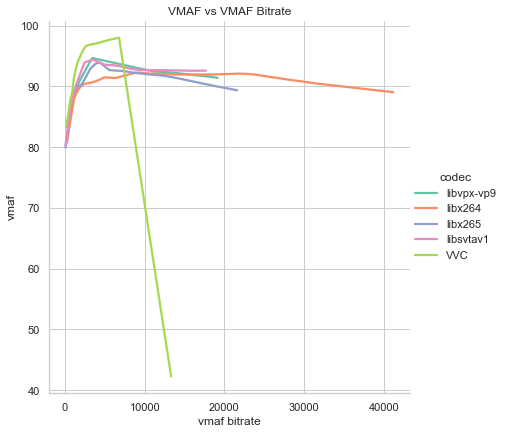

In [38]:
#VVC line when 4k data incldued is skewed due to outlier 'HDR_2160P-70ca'
#I assume HDR requires a higher bitrate for the same vmaf as other videos
sns.lmplot(data=VideoDataInstance.powers_df, x="vmaf bitrate", y="vmaf", hue="codec", lowess=True, scatter=False, height=6, palette="Set2")
ax = plt.gca()
ax.set_title("VMAF vs VMAF Bitrate")
plt.savefig("VMAF_vs_Bitrate_lowess_VVC_2160.pdf")

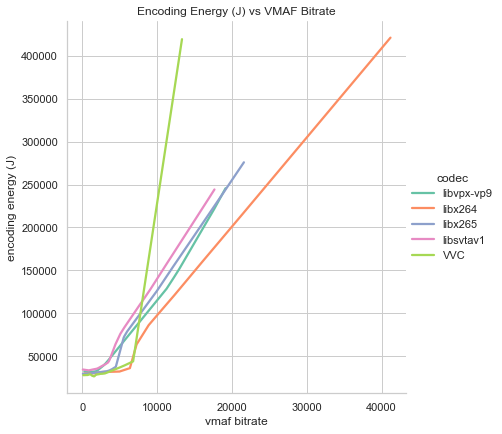

In [40]:
sns.lmplot(data=VideoDataInstance.powers_df, y="encoding energy (J)", x="vmaf bitrate", hue="codec", scatter=False, lowess=True, ci=None, height=6, palette="Set2", legend=True)
ax = plt.gca()
ax.set_title("Encoding Energy (J) vs VMAF Bitrate")
plt.savefig("encoding_energy_vs_Bitrate_lowess_VVC_2160.pdf")

Text(0.5, 1.0, 'VMAF vs Encoding Energy (J)')

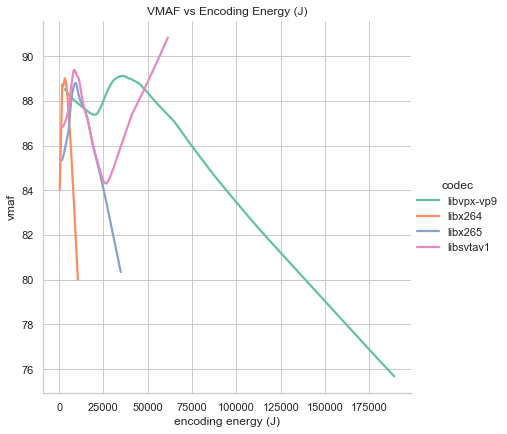

In [68]:
sns.lmplot(data=VideoDataInstance.powers_df[VideoDataInstance.powers_df.codec != "VVC"], x="encoding energy (J)", y="vmaf", hue="codec", scatter=False, lowess=True, ci=None, height=6, palette="Set2", legend=True)
ax = plt.gca()
ax.set_title("VMAF vs Encoding Energy (J)")

<AxesSubplot:xlabel='vmaf bitrate', ylabel='encoding energy (J)'>

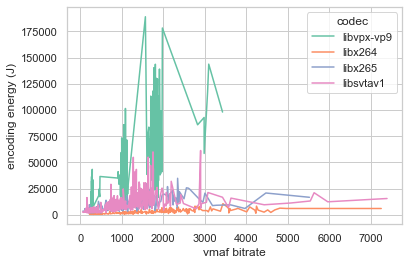

In [106]:
sns.lineplot(x="vmaf bitrate", y="encoding energy (J)", hue="codec", data=test_df, palette="Set2", ci=None)

<AxesSubplot:xlabel='encoding energy (J)', ylabel='vmaf'>

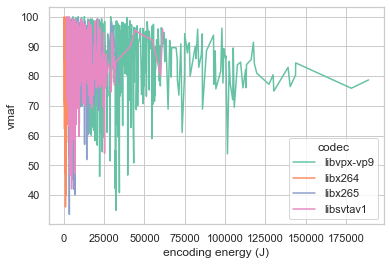

In [111]:
sns.lineplot(x="encoding energy (J)", y="vmaf", hue="codec", data=test_df, palette="Set2", ci=None)

## Exporting to Excel

In [10]:
#Dump df into excel with cells of objects
test_df = pd.DataFrame.from_dict(VideoDataInstance.videos_flat, orient="index")
# test_df.to_excel("full_data.xlsx")

In [14]:
#Formatted excel spreadsheet
test_dict = {}

for vid in VideoDataInstance.videos_flat.values():
    if "vmaf_target" not in vid:
        test_dict[f"{vid['video_name']}-{vid['resolution']}-{vid['codec']}"] = {"resolution": vid["resolution"], 
                                                             "target_encode_bitrate": vid["target_encode"]["bitrate"],  
                                                             "target_encode_qp": vid["target_encode"]["qp"], 
                                                             "target_encode_vmaf": vid["target_encode"]["vmaf"],
                                                             "vmaf_target_bitrate": None,  
                                                             "vmaf_target_qp": None, 
                                                             "vmaf_target_vmaf": None,
                                                             "evaluated_qp_energy": vid["evaluated_qp_energy"], 
                                                             "target_encode_energy": vid["target_encode"]["energy"],  
                                                             "codec": vid["codec"],
                                                             "genre": vid["video_name"].split("_")[0],
                                                             "org_res": int(vid["video_name"].split("_")[1].split("-")[0][:-1]),
                                                             "hash_id": vid["video_name"].split("_")[1].split("-")[1],
                                                             "video_path": vid["target_encode"]["output_video_file_path"]}        
    else:
        test_dict[f"{vid['video_name']}-{vid['resolution']}-{vid['codec']}"] = {"resolution": vid["resolution"], 
                                                             "target_encode_bitrate": vid["target_encode"]["bitrate"],  
                                                             "target_encode_qp": vid["target_encode"]["qp"], 
                                                             "target_encode_vmaf": vid["target_encode"]["vmaf"],
                                                             "vmaf_target_bitrate": vid["vmaf_target"]["bitrate"],  
                                                             "vmaf_target_qp": vid["vmaf_target"]["qp"], 
                                                             "vmaf_target_vmaf": vid["vmaf_target"]["vmaf"],
                                                             "evaluated_qp_energy": vid["evaluated_qp_energy"], 
                                                             "target_encode_energy": vid["target_encode"]["energy"],  
                                                             "codec": vid["codec"],
                                                             "genre": vid["video_name"].split("_")[0],
                                                             "org_res": int(vid["video_name"].split("_")[1].split("-")[0][:-1]),
                                                             "hash_id": vid["video_name"].split("_")[1].split("-")[1],
                                                             "video_path": vid["target_encode"]["output_video_file_path"]}

test_dict_df = pd.DataFrame.from_dict(test_dict, orient="index")
test_dict_df.to_excel("formatted_data.xlsx")
# test_dict_df

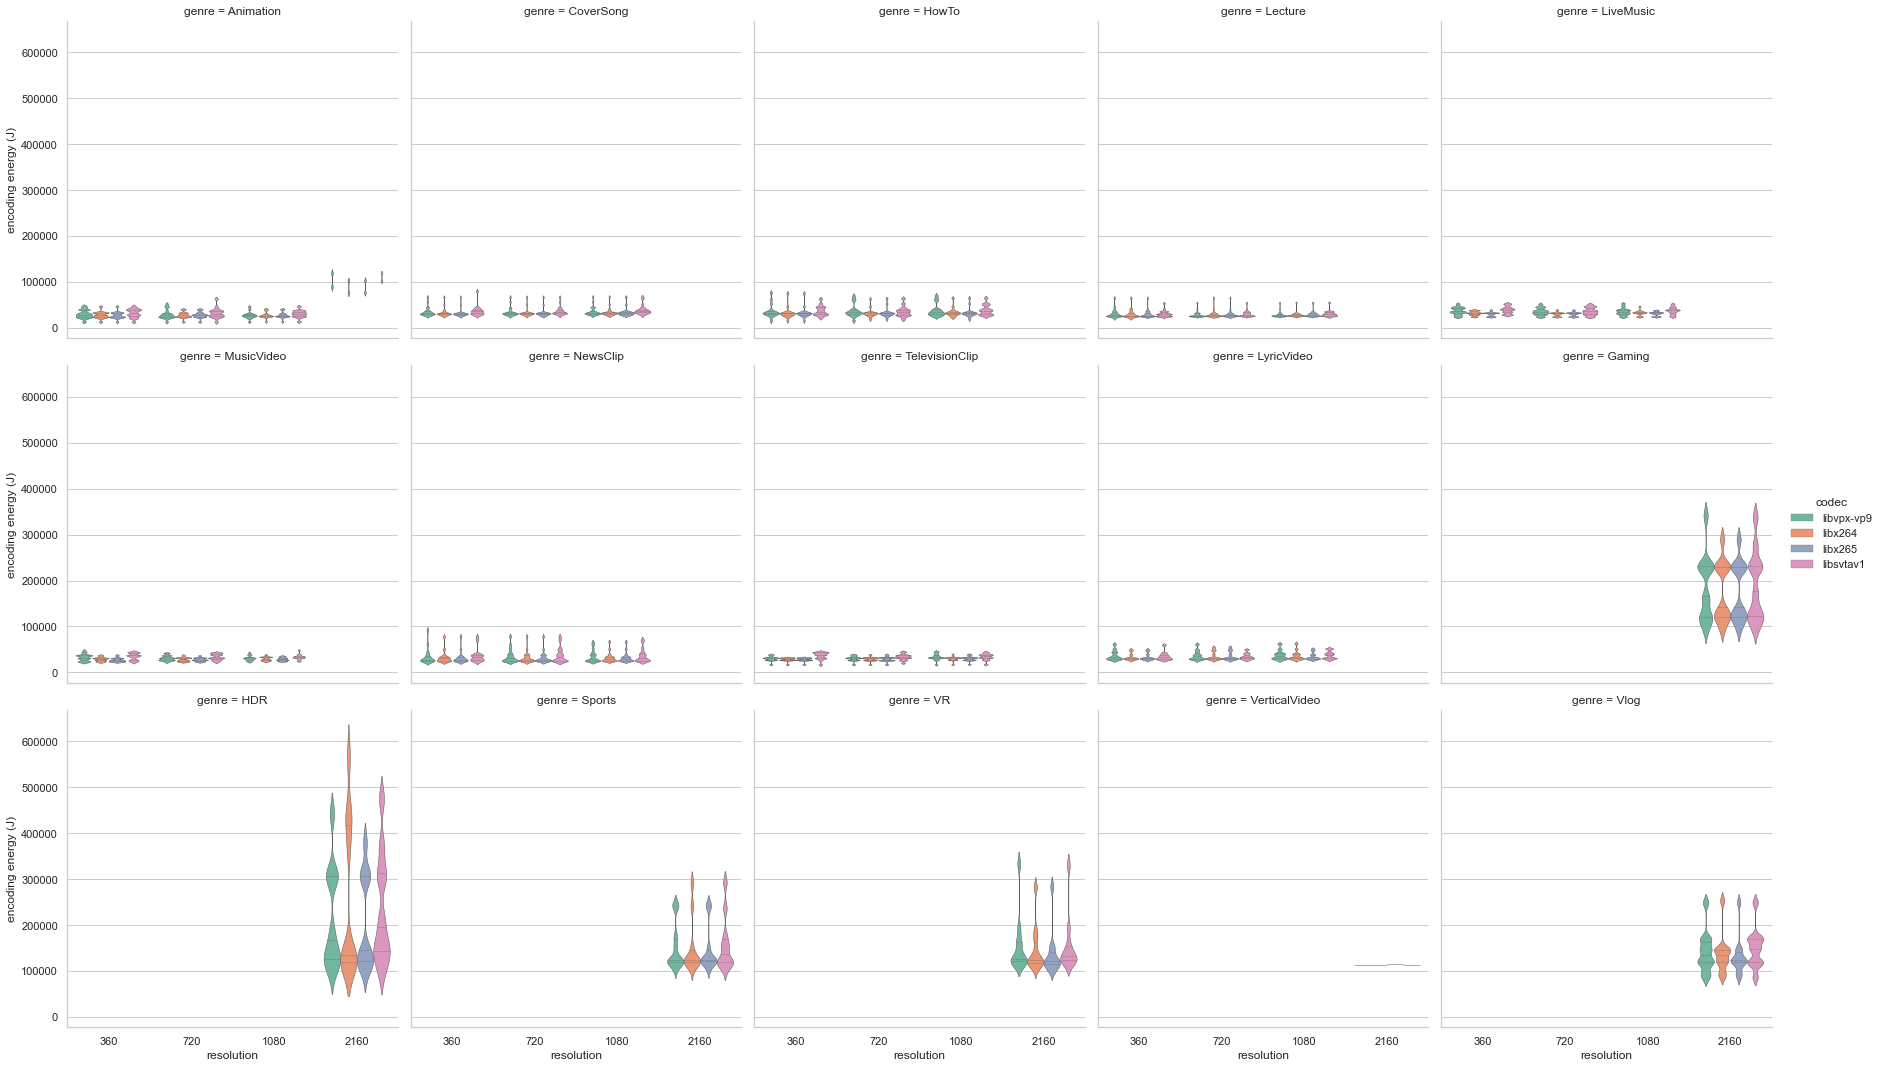

In [23]:
VideoDataInstance.get_violin_graphs()


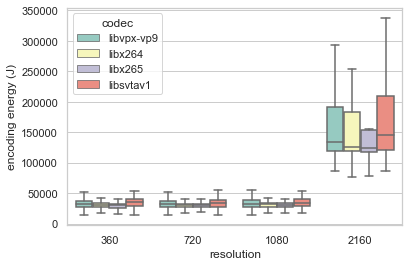

In [24]:
VideoDataInstance.get_res_energy_graph()

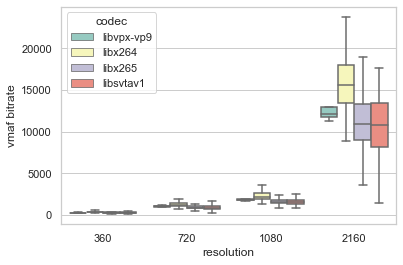

In [25]:
VideoDataInstance.get_res_bitrate_graph()

## Number of Errors

In [169]:
with open("power/db_vmaf_yuv_2022-06-09.json") as f:
    vmaf_data = json.load(f)


errors = {}

for codec in vmaf_data.keys():

    for i, vid in enumerate(vmaf_data[codec].values()):
        if "error" in vid:
            errors.setdefault(codec, []).append(vid)
            # errors.setdefault(codec, []).append({"video_name": vid["video_name"], "resolution": vid["resolution"]})

In [170]:
with open("errors_full.json", "w") as f:
    json.dump(errors, f)

In [140]:
print(errors.keys())
print(len(errors["libvpx-vp9"]))
print(len(errors["libx264"]))
print(len(errors["libx265"]))
print(len(errors["libsvtav1"]))
print(len(errors["VVC"]))

dict_keys(['libvpx-vp9', 'libx264', 'libx265', 'libsvtav1', 'VVC'])
579
586
587
598
801


### Size Difference

In [15]:
rounded_mem = df_rounded.memory_usage(deep=True).sum()
unrounded_mem = df_unrounded.memory_usage(deep=True).sum()

print(f"Difference in memory usage: {(rounded_mem - unrounded_mem) / ((rounded_mem + unrounded_mem) / 2) * 100}")

rounded_file_size = 160007256
unrounded_file_size = 349845153

print(f"Difference in file size: {(rounded_file_size - unrounded_file_size) / ((rounded_file_size + unrounded_file_size) / 2) * 100}")

Difference in memory usage: -62.24425577626855
Difference in file size: -74.46778465648084


In [19]:
print(f"Unrounded file size is {unrounded_file_size/rounded_file_size}x larger")
print(f"Unrounded memory requirement is {unrounded_mem/rounded_mem}x more")

Unrounded file size is 2.186433051511114x larger
Unrounded memory requirement is 1.9036901673613928x more


In [9]:
for vid in vids_flat.values():
    video_times = get_video_time(vid)
    energies = get_energy_video(df_unrounded, video_times)
    
    evaluated_qp_energy = sum(energies[:-1])[0]
    target_encode_energy = energies[-1][0]
    
    for i, qp in enumerate(vid["evaluated_qps"]):
        qp["energy"] = energies[i][0]
        
    vid["target_encode"]["energy"] = target_encode_energy
    
    vid["evaluated_qp_energy"] = evaluated_qp_energy
    
vids_flat

{'0-libvpx-vp9': {'video_name': 'Animation_1080P-05f8',
  'resolution': 360,
  'evaluated_qps': [{'output_video_file_path': '/home/csxds/video_temp/videos/Animation_05f8_640x360_libvpx-vp9_27.mp4',
    'bitrate': 1650.553,
    'start_time': '2022-05-02 15:40:31.537',
    'end_time': '2022-05-02 15:41:04.308',
    'qp': 27,
    'vmaf': 92.546579,
    'start_time_vmaf': '2022-05-02 15:41:05.883',
    'end_time_vmaf': '2022-05-02 15:41:48.925',
    'vvcdec_output_path': None,
    'resized': True,
    'energy': 3758.9199394736843},
   {'output_video_file_path': '/home/csxds/video_temp/videos/Animation_05f8_640x360_libvpx-vp9_33.mp4',
    'bitrate': 1058.271,
    'start_time': '2022-05-02 15:41:49.071',
    'end_time': '2022-05-02 15:42:17.777',
    'qp': 33,
    'vmaf': 90.232278,
    'start_time_vmaf': '2022-05-02 15:42:19.354',
    'end_time_vmaf': '2022-05-02 15:43:02.277',
    'vvcdec_output_path': None,
    'resized': True,
    'energy': 3306.9503373333337},
   {'output_video_file_pat

### Tests

In [121]:
vid_times = get_video_time(vids_flat["0-libvpx-vp9"])

def test_get_video_times():
    vid_times = get_video_time(vids_flat["0-libvpx-vp9"])
    assert vid_times == [['2022-05-02 15:40:31.537', '2022-05-02 15:41:04.308'], ['2022-05-02 15:41:49.071', '2022-05-02 15:42:17.777'], ['2022-05-02 15:43:02.430', '2022-05-02 15:43:25.563'], ['2022-05-02 15:44:11.118', '2022-05-02 15:44:30.494'], ['2022-05-02 15:45:15.068', '2022-05-02 15:45:31.851'], ['2022-05-02 15:46:15.988', '2022-05-02 15:46:34.355']]
    
def test_get_energy_video():
    vid_energy = get_energy_video(df_unrounded, vid_times)
    evaluated_qp_energy = sum(vid_energy[:-1])[0]
    target_encode_energy = vid_energy[-1][0]
    
    assert evaluated_qp_energy == qp_energy[0]
    assert target_encode_energy == energy_target[0]

def run_tests():
    test_get_video_times()
    test_get_energy_video()
    print("Passed")
    
run_tests()

Passed


# Filling Gaps

In [46]:
def fill_gaps(df):
    deltas = df.index.to_series().diff()
    df.insert(1, "delta", deltas.dt.seconds)
    
    newdf = df.query('delta == 2')
    
    missing_times = newdf.index.to_frame().apply(lambda x: x - timedelta(0, 1))
    missing_times = missing_times.assign(power = lambda x: (df.loc[x.index]['power'] + df.loc[x.index - timedelta(0, 2)]['power'].values) / 2)
    missing_times.set_index('datetime', inplace=True)
    
    res = df.append(missing_times, ignore_index=False)
    res.sort_index(inplace=True)
    res = res.drop(columns=["delta"])
    df = df.drop(columns=["delta"])
    
    return res

In [34]:
df = df_rounded
deltas = df.index.to_series().diff()
df.insert(1, "delta", deltas.dt.seconds)

In [300]:
newdf = df.query('delta == 2')

In [305]:
missing_times = newdf.index.to_frame().apply(lambda x: x - timedelta(0, 1))

missing_times = missing_times.assign(power = lambda x: (df.loc[x.index]['power'] + df.loc[x.index - timedelta(0, 2)]['power'].values) / 2)
missing_times.set_index('datetime', inplace=True)
missing_times

power
datetime                       
2022-02-14 15:06:19  115.312500
2022-02-14 15:09:14  114.421875
2022-02-14 15:16:12  115.296875
2022-02-14 15:20:09  211.250000
2022-02-14 15:24:00  170.843750
...                         ...
2022-06-13 09:12:32   80.390625
2022-06-13 09:12:35   79.875000
2022-06-13 09:13:29   81.078125
2022-06-13 09:13:31   80.531250
2022-06-13 09:15:27   80.656250

[23956 rows x 1 columns]

In [307]:
res = df.append(test, ignore_index=False)
res.sort_index(inplace=True)
res = res.drop(columns=["delta"])
res

power
datetime                      
2022-02-14 15:05:56  115.87500
2022-02-14 15:05:57  116.18750
2022-02-14 15:05:58  115.53125
2022-02-14 15:05:59  114.37500
2022-02-14 15:06:00  114.09375
...                        ...
2022-06-13 09:19:18   80.93750
2022-06-13 09:19:19   79.68750
2022-06-13 09:19:20   80.06250
2022-06-13 09:19:21   81.03125
2022-06-13 09:19:22   81.93750

[5924122 rows x 1 columns]

In [308]:
res.iloc[[22,23,24,25,192,193]]

power
datetime                       
2022-02-14 15:06:18  114.437500
2022-02-14 15:06:19  115.312500
2022-02-14 15:06:20  116.187500
2022-02-14 15:06:21  115.125000
2022-02-14 15:09:12  115.020833
2022-02-14 15:09:13  113.906250

In [309]:
df.iloc[[22,23,24,25,192,193]]

power  delta
datetime                             
2022-02-14 15:06:18  114.43750    1.0
2022-02-14 15:06:20  116.18750    2.0
2022-02-14 15:06:21  115.12500    1.0
2022-02-14 15:06:22  114.03125    1.0
2022-02-14 15:09:13  113.90625    1.0
2022-02-14 15:09:15  114.93750    2.0

In [311]:
deltas = res.index.to_series().diff()
res.insert(1, "delta", deltas.dt.seconds)

ValueError: cannot insert delta, already exists

In [315]:
test = res.query('delta == 2')
test

Empty DataFrame
Columns: [power, delta]
Index: []

In [35]:
gaps = deltas[deltas > timedelta(0, 1)]
gaps

23        0 days 00:00:02
72        0 days 00:00:05
193       0 days 00:00:02
238       0 days 00:00:33
578       0 days 00:00:02
                ...      
5899760   0 days 00:00:02
5899762   0 days 00:00:02
5899815   0 days 00:00:02
5899816   0 days 00:00:02
5899931   0 days 00:00:02
Name: datetime, Length: 24156, dtype: timedelta64[ns]

In [36]:
sorted_gaps = gaps.sort_values(ascending=False)

In [37]:
sorted_gaps

1686122   44 days 13:31:00
2890453    2 days 18:06:15
1686147    1 days 08:25:01
427950     1 days 01:07:40
2293730    0 days 05:44:16
                ...       
1921153    0 days 00:00:02
1920750    0 days 00:00:02
1920578    0 days 00:00:02
1920406    0 days 00:00:02
5899931    0 days 00:00:02
Name: datetime, Length: 24156, dtype: timedelta64[ns]

In [ ]:
23750

In [42]:
deltas2 = df2['datetime'].diff()
gaps2 = deltas2[deltas2 > timedelta(0, 1)]
sorted_gaps2 = gaps2.sort_values(ascending=False)

In [43]:
sorted_gaps2

9558891    44 days 13:31:00
15704415    2 days 18:06:15
9559044     1 days 08:25:01
2436390     1 days 01:07:40
13003467    0 days 05:44:16
                 ...       
10889478    0 days 00:00:02
10887021    0 days 00:00:02
10885968    0 days 00:00:02
10884915    0 days 00:00:02
29123823    0 days 00:00:02
Name: datetime, Length: 24156, dtype: timedelta64[ns]

In [47]:
sorted_gaps2[sorted_gaps2 < timedelta(0, 3)]

20048956   0 days 00:00:02
20048492   0 days 00:00:02
20093890   0 days 00:00:02
20103058   0 days 00:00:02
20134818   0 days 00:00:02
                 ...      
10889478   0 days 00:00:02
10887021   0 days 00:00:02
10885968   0 days 00:00:02
10884915   0 days 00:00:02
29123823   0 days 00:00:02
Name: datetime, Length: 23956, dtype: timedelta64[ns]

# Fixing 10 watt difference

In [125]:
# df = pd.read_csv('power/power_log_2022-05-26.csv', names=['datetime', 'power'], dtype={'datetime': "string", "power": float}, usecols=(0, 1), low_memory=False)
df = pd.read_csv('test10.csv', dtype={'datetime': "string", "power": float}, usecols=(0, 1), low_memory=False)
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index('datetime', inplace=True)

In [126]:
df

power
datetime                   
2022-02-14 15:05:56  116.06
2022-02-14 15:05:57  116.00
2022-02-14 15:05:58  114.94
2022-02-14 15:05:59  114.10
2022-02-14 15:06:00  114.25
...                     ...
2022-06-13 09:19:18   79.70
2022-06-13 09:19:19   80.30
2022-06-13 09:19:20   80.50
2022-06-13 09:19:21   81.80
2022-06-13 09:19:22   81.06

[5900552 rows x 1 columns]

<AxesSubplot:xlabel='datetime'>

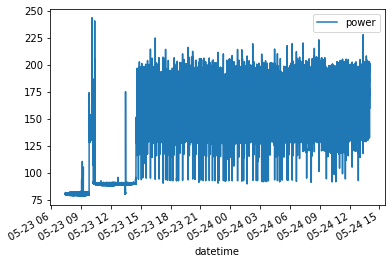

In [127]:
df['23-05-2022 07:25':'24-05-2022 14:00'].plot()

<AxesSubplot:xlabel='datetime'>

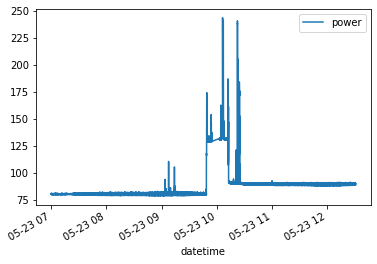

In [69]:
df['23-05-2022 07:00':'23-05-2022 12:30'].plot()

In [71]:
lower_power = df["23-05-2022 7:00" : "23-05-2022 9:00"]
higher_power = df["23-05-2022 10:30" : "23-05-2022 12:30"]

In [88]:
print(f"Lower avg: {lower_power.mean().values[0]}, higher avg: {higher_power.mean().values[0]}, diff: {higher_power.mean().values[0] - lower_power.mean().values[0]}")

Lower avg: 80.45737104135029, higher avg: 89.62018398118708, diff: 9.162812939836797


In [219]:
df.loc["23-05-2022 09:48"]

power
datetime                       
2022-05-23 09:48:00   79.900000
2022-05-23 09:48:01   79.800000
2022-05-23 09:48:02   80.500000
2022-05-23 09:48:03   81.300000
2022-05-23 09:48:04   81.100000
2022-05-23 09:48:05   80.750000
2022-05-23 09:48:06   79.750000
2022-05-23 09:48:07   80.250000
2022-05-23 09:48:08   81.000000
2022-05-23 09:48:09   81.250000
2022-05-23 09:48:10   80.800000
2022-05-23 09:48:11   80.400000
2022-05-23 09:48:12   79.600000
2022-05-23 09:48:13   80.400000
2022-05-23 09:48:14   81.060000
2022-05-23 09:48:15   81.400000
2022-05-23 09:48:16   80.900000
2022-05-23 09:48:17   79.900000
2022-05-23 09:48:18   79.750000
2022-05-23 09:48:19   80.500000
2022-05-23 09:48:20   80.900000
2022-05-23 09:48:21   81.250000
2022-05-23 09:48:22   80.600000
2022-05-23 09:48:23   79.750000
2022-05-23 09:48:24   80.000000
2022-05-23 09:48:25   80.400000
2022-05-23 09:48:26   81.400000
2022-05-23 09:48:27   81.000000
2022-05-23 09:48:28   80.440000
2022-05-23 09:48:29   79.700000
2022-05-23 09:48:30   80.100000
2022-05-23 09:48:31   80.900000
2022-05-23 09:48:32   81.750000
2022-05-23 09:48:33   81.250000
2022-05-23 09:48:34   80.200000
2022-05-23 09:48:35   79.800000
2022-05-23 09:48:36   80.560000
2022-05-23 09:48:37   81.250000
2022-05-23 09:48:38   85.500000
2022-05-23 09:48:39   80.750000
2022-05-23 09:48:40   79.750000
2022-05-23 09:48:41   79.750000
2022-05-23 09:48:42   80.750000
2022-05-23 09:48:43   81.100000
2022-05-23 09:48:44   81.700000
2022-05-23 09:48:45   80.250000
2022-05-23 09:48:46   79.750000
2022-05-23 09:48:47   83.500000
2022-05-23 09:48:48   81.437187
2022-05-23 09:48:49  103.937187
2022-05-23 09:48:50  106.237187
2022-05-23 09:48:51   88.437187
2022-05-23 09:48:52   84.737187
2022-05-23 09:48:53  100.837187
2022-05-23 09:48:54  105.087187
2022-05-23 09:48:55  106.837187
2022-05-23 09:48:56  106.587187
2022-05-23 09:48:57  105.737187
2022-05-23 09:48:58  105.637187
2022-05-23 09:48:59  106.587187

<AxesSubplot:xlabel='datetime'>

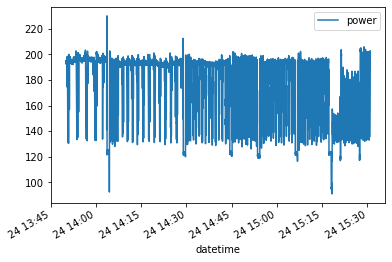

In [62]:
df['24-05-2022 13:50':'24-05-2022 15:30'].plot()

In [58]:
df.loc["24-05-2022 13:59"]

power
datetime                  
2022-05-24 13:59:00  195.9
2022-05-24 13:59:01  192.8
2022-05-24 13:59:02  189.1
2022-05-24 13:59:03  193.5
2022-05-24 13:59:04  184.0
2022-05-24 13:59:05  195.8
2022-05-24 13:59:06  194.6
2022-05-24 13:59:07  195.5
2022-05-24 13:59:08  197.0
2022-05-24 13:59:09  197.2
2022-05-24 13:59:10  196.0
2022-05-24 13:59:11  195.1
2022-05-24 13:59:12  193.9
2022-05-24 13:59:13  193.8
2022-05-24 13:59:14  195.2
2022-05-24 13:59:15  196.2
2022-05-24 13:59:16  197.2
2022-05-24 13:59:17  195.5
2022-05-24 13:59:18  196.8
2022-05-24 13:59:19  197.8
2022-05-24 13:59:20  196.8
2022-05-24 13:59:21  184.0
2022-05-24 13:59:22  181.0
2022-05-24 13:59:23  172.1
2022-05-24 13:59:24  171.2
2022-05-24 13:59:25  181.0
2022-05-24 13:59:26  190.5
2022-05-24 13:59:27  190.8
2022-05-24 13:59:28  186.2
2022-05-24 13:59:29  182.2
2022-05-24 13:59:30  179.2
2022-05-24 13:59:31  178.0
2022-05-24 13:59:32  163.5
2022-05-24 13:59:33  163.8
2022-05-24 13:59:34  163.0
2022-05-24 13:59:35  155.2
2022-05-24 13:59:36  157.5
2022-05-24 13:59:37  158.6
2022-05-24 13:59:38  153.4
2022-05-24 13:59:39  154.6
2022-05-24 13:59:40  143.0
2022-05-24 13:59:41  138.0
2022-05-24 13:59:42  132.8
2022-05-24 13:59:43  135.8
2022-05-24 13:59:44  145.5
2022-05-24 13:59:45  154.0
2022-05-24 13:59:46  163.1
2022-05-24 13:59:47  173.9
2022-05-24 13:59:48  182.6
2022-05-24 13:59:49  194.8
2022-05-24 13:59:50  188.5
2022-05-24 13:59:51  182.0
2022-05-24 13:59:52  176.2
2022-05-24 13:59:53  168.5
2022-05-24 13:59:54  168.4
2022-05-24 13:59:55  155.8
2022-05-24 13:59:56  149.8
2022-05-24 13:59:57  141.0
2022-05-24 13:59:58  132.6
2022-05-24 13:59:59  136.0